In [13]:
# For clustering
from sklearn.cluster import KMeans
# For data manipulation
import pandas as pd
import numpy as np
# Scaling features (critical for K-Means, as it's distance-sensitive)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Basic plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality reduction for visualization (e.g., PCA)
from sklearn.decomposition import PCA
# Metrics to evaluate clustering quality
from sklearn.metrics import silhouette_score, adjusted_rand_score
# Supervised models for prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Train-test split and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Import preprocessing and modeling tools
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import joblib

In [40]:
# ---------------------------
# 1. Data Cleaning
# ---------------------------
data = pd.read_csv('data/shopping_behavior_updated.csv')

In [42]:
data.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [44]:
# Display the first few rows
print("Initial Data:")
print(data.head())

Initial Data:
   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  Review Rating Subscription Status  \
0       Kentucky    L       Gray  Winter            3.1                 Yes   
1          Maine    L     Maroon  Winter            3.1                 Yes   
2  Massachusetts    S     Maroon  Spring            3.1                 Yes   
3   Rhode Island    M     Maroon  Spring            3.5                 Yes   
4         Oregon    M  Turquoise  Spring            2.7                 Yes   

   Shipping Type Discount Applied Promo Co

In [46]:
# Clean column names: remove extra spaces and replace spaces with underscores
data.columns = data.columns.str.strip().str.replace(' ', '_')

In [48]:
# Remove parentheses from column names (e.g., Purchase_Amount_(USD) -> Purchase_Amount_USD)
data.columns = data.columns.str.replace('(', '').str.replace(')', '')
print("\nCleaned Column Names:")
print(data.columns)



Cleaned Column Names:
Index(['Customer_ID', 'Age', 'Gender', 'Item_Purchased', 'Category',
       'Purchase_Amount_USD', 'Location', 'Size', 'Color', 'Season',
       'Review_Rating', 'Subscription_Status', 'Shipping_Type',
       'Discount_Applied', 'Promo_Code_Used', 'Previous_Purchases',
       'Payment_Method', 'Frequency_of_Purchases'],
      dtype='object')


In [50]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Customer_ID               0
Age                       0
Gender                    0
Item_Purchased            0
Category                  0
Purchase_Amount_USD       0
Location                  0
Size                      0
Color                     0
Season                    0
Review_Rating             0
Subscription_Status       0
Shipping_Type             0
Discount_Applied          0
Promo_Code_Used           0
Previous_Purchases        0
Payment_Method            0
Frequency_of_Purchases    0
dtype: int64


In [52]:
# For simplicity, drop rows with missing values (you can choose other strategies if needed)
data.dropna(inplace=True)

In [55]:
# ---------------------------
# 2. Data Preprocessing
# ---------------------------

# List of categorical columns to encode
categorical_cols = [
    'Gender', 'Item_Purchased', 'Category', 'Location', 'Size', 'Color',
    'Season', 'Subscription_Status', 'Shipping_Type', 'Discount_Applied',
    'Promo_Code_Used', 'Payment_Method', 'Frequency_of_Purchases'
]

In [61]:
# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    if col in data.columns:
        data[col] = le.fit_transform(data[col])

In [63]:
# Choose features for clustering. Based on the dataset, we select:
# Age, Purchase_Amount_USD, Previous_Purchases, and Review_Rating.
# Adjust feature selection based on your analysis.
features = ['Age', 'Purchase_Amount_USD', 'Previous_Purchases', 'Review_Rating']

In [65]:
# Verify the selected features exist in the DataFrame
print("\nFeatures selected for clustering:", features)
print(data[features].head())


Features selected for clustering: ['Age', 'Purchase_Amount_USD', 'Previous_Purchases', 'Review_Rating']
   Age  Purchase_Amount_USD  Previous_Purchases  Review_Rating
0   55                   53                  14            3.1
1   19                   64                   2            3.1
2   50                   73                  23            3.1
3   21                   90                  49            3.5
4   45                   49                  31            2.7


In [69]:
# Scale the features for better clustering performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

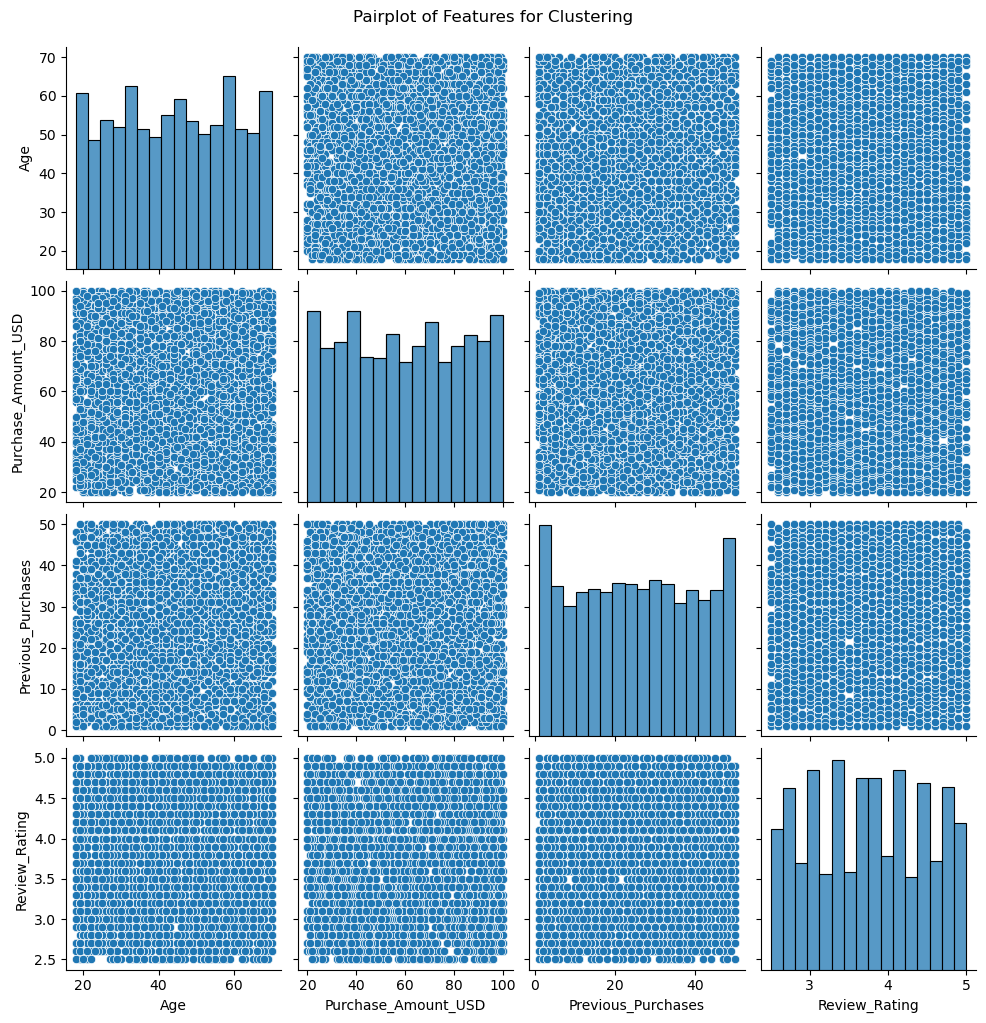

In [71]:
# ---------------------------
# 3. Data Visualization
# ---------------------------

# Pair plot of the selected features
sns.pairplot(data[features])
plt.suptitle("Pairplot of Features for Clustering", y=1.02)
plt.show()

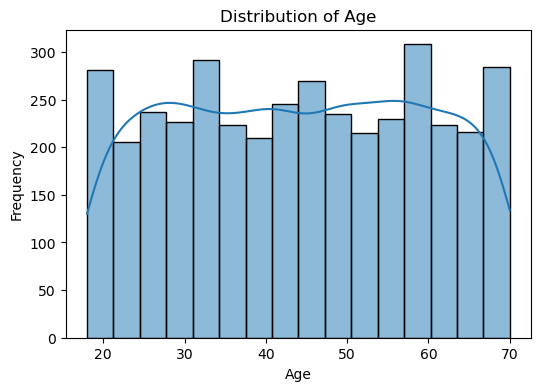

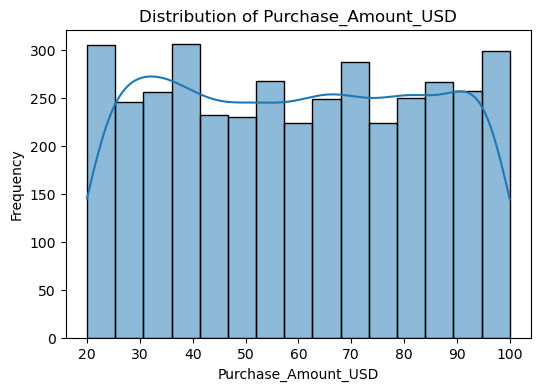

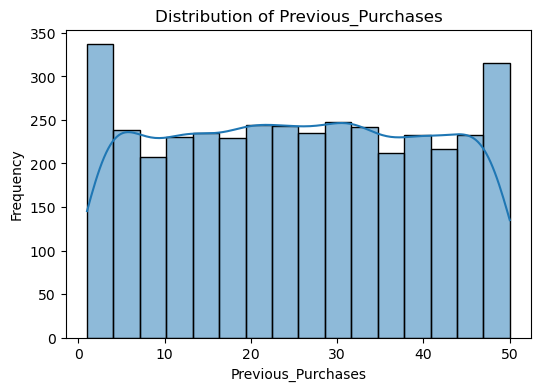

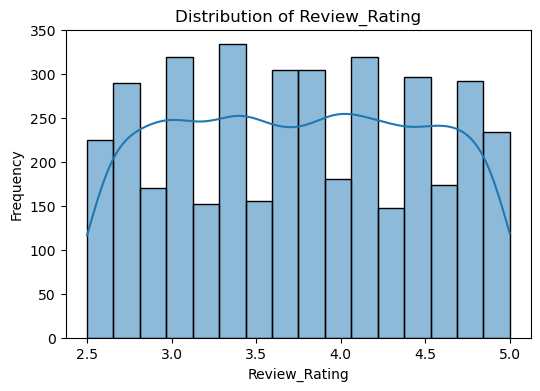

In [73]:
# Plot distributions for each selected feature
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [75]:
# ---------------------------
# 4. Train K-Means Model
# ---------------------------

# Decide on number of clusters (e.g., 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [77]:
# Assign the cluster labels to the original DataFrame
data['Cluster'] = kmeans.labels_

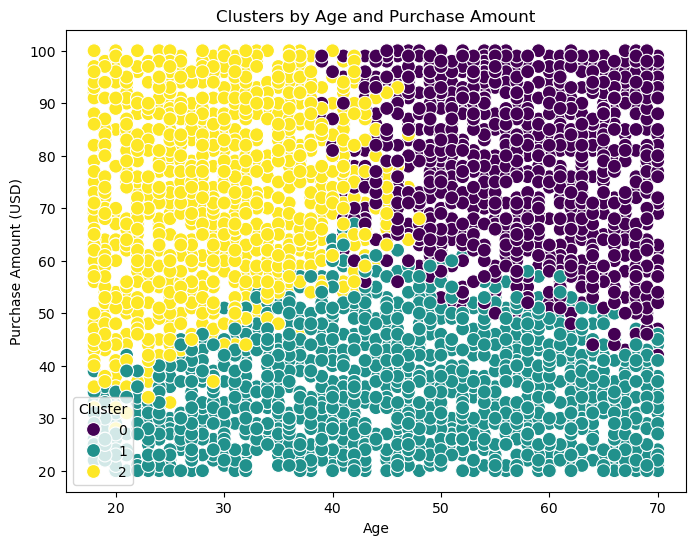

In [81]:
# Visualize clusters using a scatter plot (e.g., Age vs. Purchase Amount)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Age', y='Purchase_Amount_USD', hue='Cluster', palette='viridis', s=100)
plt.title("Clusters by Age and Purchase Amount")
plt.xlabel("Age")
plt.ylabel("Purchase Amount (USD)")
plt.legend(title="Cluster")
plt.show()

In [83]:
# ---------------------------
# 5. Save the Trained Model
# ---------------------------

# Save the K-Means model to a file
joblib.dump(kmeans, 'kmeans_model.pkl')
# It is a good practice to also save the scaler for future data transformation
joblib.dump(scaler, 'scaler.pkl')

print("K-Means model and scaler saved successfully!")

K-Means model and scaler saved successfully!
